In [1]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge

In [2]:
HARTREE_TO_EV = 27.211386245988
'''train_subset = "0:50000"  #input for ase.io.read command
test_subset = "50000:55000"  #input to ase.io.read command
environments_for_fitting = 1000 #number of environments to fit nice transfomers
GRID = [150, 200, 350, 500, 750, 1000, 1500, 2000, 2500, 3500, 5000, 7500, 10000, 15000, 20000, 35000, 50000]  #for learning curve

#HYPERS for librascal spherical expansion coefficients
LAMBDA_MAX = 5
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}'''

train_subset = "0:200"  #input for ase.io.read command
test_subset = "200:250"  #input to ase.io.read command
environments_for_fitting = 100 #number of environments to fit nice transfomers
GRID = [150, 200]
#HYPERS for librascal spherical expansion coefficients
LAMBDA_MAX = 3
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}
MAGIC_NUMBER = 10000
ALPHA = 1e-1
N_COMPRESS = 5


'''MAGIC_NUMBER = 10000
ALPHA = 1e-9
N_COMPRESS = 20'''
train_structures = ase.io.read('methane.extxyz', index=train_subset)

test_structures = ase.io.read('methane.extxyz', index=test_subset)

all_species = get_all_species(train_structures + test_structures)

train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV
e_mean = np.mean(train_energies)
train_energies -= e_mean

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV
test_energies -= e_mean
print(np.min(train_energies), np.max(train_energies))

-6.458165243625672 21.9666209428583


# NICE cython

In [3]:
'''#our model:
def get_nice():
    return StandardSequence([
        StandardBlock(ThresholdExpansioner(),
                      CovariantsPurifierBoth(regressor = Ridge(alpha = ALPHA), num_to_fit='1000x'),
                      IndividualLambdaPCAsBoth(n_components=20),
                      None,
                      None,
                      None),
        StandardBlock(ThresholdExpansioner(),
                      CovariantsPurifierBoth(regressor = Ridge(alpha = ALPHA), num_to_fit='1000x'),
                      IndividualLambdaPCAsBoth(n_components=20),
                      None,
                      None,
                      None),
        StandardBlock(ThresholdExpansioner(),
                      CovariantsPurifierBoth(regressor = Ridge(alpha = ALPHA), num_to_fit='1000x'),
                      IndividualLambdaPCAsBoth(n_components=20),
                      None,
                      None,
                      None),
       
    ],
                   )'''


def get_nice():
    return StandardSequence([
        StandardBlock(ThresholdExpansioner(),
                      None,
                      IndividualLambdaPCAsBoth(n_components=N_COMPRESS),
                      None,
                      None,
                      None),
        StandardBlock(ThresholdExpansioner(),
                      None,
                      IndividualLambdaPCAsBoth(n_components=N_COMPRESS),
                      None,
                      None,
                      None),
        StandardBlock(ThresholdExpansioner(),
                      None,
                      IndividualLambdaPCAsBoth(n_components=N_COMPRESS),
                      None,
                      None,
                      None),
       
    ],
                   )

In [4]:
train_coefficients = get_spherical_expansion(train_structures, HYPERS,
                                             all_species)

test_coefficients = get_spherical_expansion(test_structures, HYPERS,
                                            all_species)

for key in train_coefficients.keys():
    train_coefficients[key] *= MAGIC_NUMBER
    test_coefficients[key] *= MAGIC_NUMBER



100%|██████████| 2/2 [00:00<00:00, 6074.30it/s]


In [5]:
'''nice = {}
for key in train_coefficients.keys():
    nice[key] = get_nice()
np.random.seed(0)
for key in train_coefficients.keys():
    nice[key].fit(train_coefficients[key][:environments_for_fitting])'''

'nice = {}\nfor key in train_coefficients.keys():\n    nice[key] = get_nice()\nnp.random.seed(0)\nfor key in train_coefficients.keys():\n    nice[key].fit(train_coefficients[key][:environments_for_fitting])'

In [6]:
'''model = get_nice()
np.random.seed(0)
all_coefficients = np.concatenate([train_coefficients[1], train_coefficients[6]], axis = 0)
print(all_coefficients.shape)
p = np.random.permutation(all_coefficients.shape[0])
all_coefficients = all_coefficients[p]
model.fit(all_coefficients[:environments_for_fitting])

nice = {}
for key in train_coefficients.keys():
    nice[key] = model'''

'model = get_nice()\nnp.random.seed(0)\nall_coefficients = np.concatenate([train_coefficients[1], train_coefficients[6]], axis = 0)\nprint(all_coefficients.shape)\np = np.random.permutation(all_coefficients.shape[0])\nall_coefficients = all_coefficients[p]\nmodel.fit(all_coefficients[:environments_for_fitting])\n\nnice = {}\nfor key in train_coefficients.keys():\n    nice[key] = model'

In [7]:
nice = {}
np.random.seed(0)
for key in train_coefficients.keys():
    nice[key] = get_nice()
    nice[key].fit(train_coefficients[key][:environments_for_fitting])

In [8]:
train_features = transform_sequentially(nice, train_structures, HYPERS,
                                        all_species)
test_features = transform_sequentially(nice, test_structures, HYPERS,
                                       all_species)

100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


In [9]:
print(train_features.shape)
#print(train_features[1][0:10])
#print(train_features[2][0:10])

(200, 50)


In [10]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second)**2))


def get_standard_deviation(values):
    return np.sqrt(np.mean((values - np.mean(values))**2))


def get_relative_performance(predictions, values):
    return get_rmse(predictions, values) / get_standard_deviation(values)


def estimate_performance(regressor, data_train, data_test, targets_train,
                         targets_test):
    regressor.fit(data_train, targets_train)
    return get_relative_performance(regressor.predict(data_test), targets_test)

def get_lr(regressor, data_train, data_test, targets_train,
           targets_test):
    result = []
    for el in GRID:
        result.append(estimate_performance(regressor, data_train[:el], data_test,
                                           targets_train[:el], targets_test))
    return result

In [11]:
print(train_features.shape)

(200, 50)


No handles with labels found to put in legend.


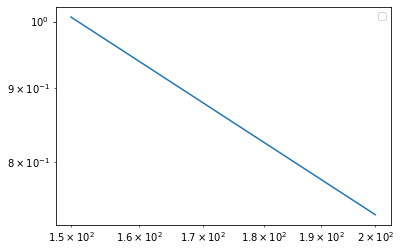

In [12]:
lr = get_lr(BayesianRidge(), train_features, test_features, train_energies, test_energies)
plt.plot(GRID, lr)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

(200, 10)
(200, 15)
(200, 20)
(200, 25)


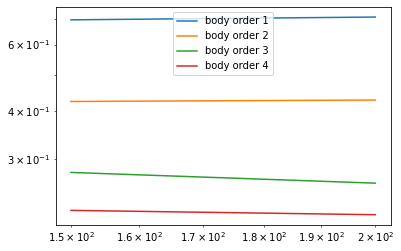

In [13]:
train_features = nice[6].transform(train_coefficients[6], return_only_invariants = True)
test_features = nice[6].transform(test_coefficients[6], return_only_invariants = True)

for index in range(1, 5):
    train = [train_features[i] for i in range(1, index + 1)]
    test = [test_features[i] for i in range(1, index + 1)]
    train = np.concatenate(train, axis = 1)
    test = np.concatenate(test, axis = 1)
    print(train.shape)
    lr = get_lr(BayesianRidge(), train, test, train_energies, test_energies)
    plt.plot(GRID, lr, label = "body order {}".format(index))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# NICE pytorch

In [14]:
from pytorch_prototype.nice_blocks import *
from pytorch_prototype.utilities import *

In [15]:
def split(coefficients):
    lambd_max = max(coefficients.keys())
    even, odd = {}, {}
    for lambd in range(lambd_max + 1):
        if lambd % 2 == 0:
            even[str(lambd)] = coefficients[lambd]
        else:
            odd[str(lambd)] = coefficients[lambd]
    return even, odd

train_coefficients = get_coefs(train_structures, HYPERS, all_species)
test_coefficients = get_coefs(test_structures, HYPERS, all_species)

                                                   
for key in train_coefficients.keys():
    train_coefficients[key] *= MAGIC_NUMBER
    test_coefficients[key] *= MAGIC_NUMBER
    
train_even, train_odd = split(train_coefficients)
test_even, test_odd = split(test_coefficients)


for key in train_even.keys():
    print(key, train_even[key].shape)
for key in test_even.keys():
    print(key, test_even[key].shape)

0 torch.Size([1000, 10, 1])
2 torch.Size([1000, 10, 5])
0 torch.Size([250, 10, 1])
2 torch.Size([250, 10, 5])


In [ ]:
class NICE_features(torch.nn.Module):
    def __init__(self, nice):
        super(NICE_features, self).__init__()
        self.nice = nice
        
    def forward(self, coefficients):
        even, odd = split(coefficients)
        even, _ = self.nice(even, odd)
        result = []
        for i in range(len(even)):
            result.append(even[i]['0'].squeeze())
        
        return {"features" : torch.cat(result, dim = 1)}
      
'''class NICE_predictions(torch.nn.Module):
    def __init__(self, nice_features):
        super(NICE_predictions, self).__init__()
        self.nice_features = nice_features'''
    
def get_torch_nice():
    blocks = [BodyOrderIteration(Expansioner(LAMBDA_MAX), 
                           Purifier(regressor = Ridge(alpha = ALPHA)),
                           Compressor(N_COMPRESS)),
         BodyOrderIteration(Expansioner(LAMBDA_MAX), 
                           Purifier(regressor = Ridge(alpha = ALPHA)),
                           Compressor(N_COMPRESS)),
         BodyOrderIteration(Expansioner(LAMBDA_MAX), 
                           Purifier(regressor = Ridge(alpha = ALPHA)),
                           Compressor(N_COMPRESS))]
    return NICE(blocks)


In [ ]:
model = get_torch_nice()
for_fit_even, for_fit_odd = {}, {}
for key in train_even.keys():
    for_fit_even[key] = train_even[key][:environments_for_fitting]
    print(for_fit_even[key].shape)
for key in test_odd.keys():
    for_fit_odd[key] = train_odd[key][:environments_for_fitting]
    print(for_fit_odd[key].shape)
model.fit(for_fit_even, for_fit_odd)

nice = {}
for key in all_species:
    nice[str(key)] = NICE_features(model)

In [ ]:
atomistic = Atomistic(nice)
train_features = atomistic(train_coefficients, central_species = get_central_species(train_structures), 
                   structural_indices = get_structural_indices(train_structures))['features']

test_features = atomistic(test_coefficients, central_species = get_central_species(test_structures), 
                   structural_indices = get_structural_indices(test_structures))['features']

train_features = train_features.data.cpu().numpy()
test_features = test_features.data.cpu().numpy()

In [ ]:
print(train_features.shape)
print(test_features.shape)

In [ ]:
lr = get_lr(BayesianRidge(), train_features, test_features, train_energies, test_energies)
plt.plot(GRID, lr, label = "body order {}".format(index))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()